# Read All Dataset CSV

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [3]:
dataset_names = []
X_trains = []
y_trains = []
X_tests = []

for folder_name in os.listdir("./Competition_data"):
    folder_path = os.path.join("./Competition_data", folder_name)
    if os.path.isdir(folder_path):
        dataset_names.append(folder_name)
        X_trains.append(pd.read_csv(f"{folder_path}/X_train.csv", header=0))
        y_trains.append(pd.read_csv(f"{folder_path}/y_train.csv", header=0))
        X_tests.append(pd.read_csv(f"{folder_path}/X_test.csv", header=0))


## Data Preprocessing & Feature Engineering

In [ ]:
def auto_identify_features(X):
    numeric_features = []
    categorical_features = []
    
    for col in X.columns:
        if X[col].dtype == 'int64' and X[col].nunique() < 10:
            categorical_features.append(col)
        elif pd.api.types.is_numeric_dtype(X[col]):
            numeric_features.append(col)
    
    return numeric_features, categorical_features

X_train_processed = []
X_test_processed = []
y_train_processed = []

for idx, folder_name in enumerate(dataset_names):
    X_train = X_trains[idx]
    X_test = X_tests[idx]    
    y_train = y_trains[idx]

    numeric_features, categorical_features = auto_identify_features(X_train)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features), 
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

    X_train_processed.append(X_resampled)
    y_train_processed.append(y_resampled)
    X_test_processed.append(X_test_scaled)

## train test split & build Model
You can select an appropriate model and perform corresponding hyperparameter tuning.

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = []
auc_scores = []

for i in range(len(dataset_names)):
    tmp_X_train, tmp_X_test, tmp_y_train, tmp_y_test = train_test_split(X_train_processed[i], y_train_processed[i], test_size=0.2, random_state=50)

    tmp_y_train = tmp_y_train.to_numpy().ravel()
    tmp_y_test = tmp_y_test.to_numpy().ravel()

    model_lgb = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=15, verbose=-1)
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_svc = SVC(probability=True, kernel='linear', random_state=42)
    model_lr = LogisticRegression(max_iter=1000, random_state=42)

    model_lgb.fit(tmp_X_train, tmp_y_train)
    model_rf.fit(tmp_X_train, tmp_y_train)
    model_svc.fit(tmp_X_train, tmp_y_train)
    model_lr.fit(tmp_X_train, tmp_y_train)

    prob_lgb = model_lgb.predict_proba(tmp_X_test)[:, 1]
    prob_rf = model_rf.predict_proba(tmp_X_test)[:, 1]
    prob_svc = model_svc.predict_proba(tmp_X_test)[:, 1]
    prob_lr = model_lr.predict_proba(tmp_X_test)[:, 1]

    auc_lgb = roc_auc_score(tmp_y_test, prob_lgb)
    auc_rf = roc_auc_score(tmp_y_test, prob_rf)
    auc_svc = roc_auc_score(tmp_y_test, prob_svc)
    auc_lr = roc_auc_score(tmp_y_test, prob_lr)

    weights = [auc_lgb, auc_rf, auc_svc, auc_lr]

    voting_clf = VotingClassifier(estimators=[
        ('lgb', model_lgb),
        ('rf', model_rf),
        ('svc', model_svc),
        ('lr', model_lr)
    ], voting='soft', weights=weights)

    voting_clf.fit(tmp_X_train, tmp_y_train)

    tmp_y_prob = voting_clf.predict_proba(tmp_X_test)[:, 1]

    auc = roc_auc_score(tmp_y_test, tmp_y_prob)

    models.append(voting_clf)
    auc_scores.append(auc)

for score in auc_scores:
    print(f"AUC: {score:.4f}")


AUC: 0.9994
AUC: 0.8608
AUC: 1.0000
AUC: 0.8373
AUC: 0.9898
AUC: 1.0000
AUC: 0.6531
AUC: 0.9253
AUC: 1.0000
AUC: 1.0000
AUC: 1.0000
AUC: 1.0000
AUC: 0.9824
AUC: 0.9994
AUC: 0.9593
AUC: 0.9667
AUC: 0.8373
AUC: 1.0000
AUC: 0.7983
AUC: 0.9494
AUC: 0.8747
AUC: 0.9779
AUC: 0.8733
AUC: 0.9943
AUC: 0.9269
AUC: 0.8746
AUC: 0.9659
AUC: 1.0000
AUC: 0.9530
AUC: 0.9979
AUC: 0.8532
AUC: 0.9976
AUC: 0.8875
AUC: 0.9984
AUC: 0.8178
AUC: 0.9820
AUC: 0.8594
AUC: 0.9940
AUC: 0.9228
AUC: 0.9971
AUC: 0.9605
AUC: 1.0000
AUC: 1.0000
AUC: 0.9850
AUC: 0.9860
AUC: 0.8566
AUC: 0.9798
AUC: 0.9071
AUC: 0.8608


/var/folders/0r/s9_2vrjn5qjdcr7gpx6_sd480000gn/T/ipykernel_54732/2260554347.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUC', data=auc_df, palette='Blues_d')


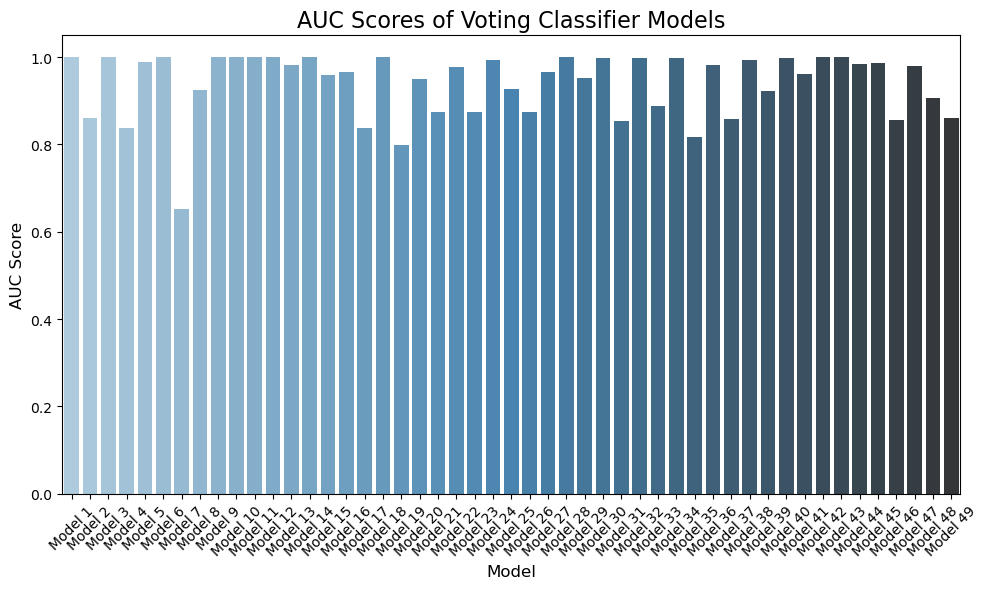

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model_names = [f'Model {i+1}' for i in range(len(auc_scores))]

auc_df = pd.DataFrame({
    'Model': model_names,
    'AUC': auc_scores
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='AUC', data=auc_df, hue='Model', palette='Blues_d', legend=False)

plt.title('AUC Scores of Voting Classifier Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Inference Model

In [7]:
y_predicts=[]
for i in range(len(dataset_names)):
    y_predict_proba=models[i].predict_proba(X_test_processed[i])[:, 1]
    df = pd.DataFrame(y_predict_proba, columns=['y_predict_proba'])
    y_predicts.append(df)
    

## Save result

In [8]:
for idx,dataset_name in enumerate(dataset_names):
    df=y_predicts[idx]
    df.to_csv(f'./Competition_data/{dataset_name}/y_predict.csv', index=False,header=True)